In [0]:
import os

if os.path.exists("physionet.org/files/challenge-2017/1.0.0/training/") == False:
  ! wget -r -N -c -np -nv -q https://physionet.org/files/challenge-2017/1.0.0/

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy import signal
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
import time
from matplotlib import style

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on GPU -", device )
else:
  device = torch.device("cpu")
  print("Running on CPU -", device )

# to run on gpu .to(device)

REBUILD_DATA = True # processing data

Running on CPU - cpu


In [0]:
"""
Copyright (c) 2013 Jami Pekkanen

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

import sys
import numpy as np
import scipy.signal
import scipy.ndimage

def detect_beats(
		ecg,	# The raw ECG signal
		rate,	# Sampling rate in HZ
		# Window size in seconds to use for 
		ransac_window_size=5.0,
		# Low frequency of the band pass filter
		lowfreq=5.0,
		# High frequency of the band pass filter
		highfreq=15.0,
		):
	"""
	ECG heart beat detection based on
	http://link.springer.com/article/10.1007/s13239-011-0065-3/fulltext.html
	with some tweaks (mainly robust estimation of the rectified signal
	cutoff threshold).
	"""

	ransac_window_size = int(ransac_window_size*rate)

	lowpass = scipy.signal.butter(1, highfreq/(rate/2.0), 'low')
	highpass = scipy.signal.butter(1, lowfreq/(rate/2.0), 'high')
	# TODO: Could use an actual bandpass filter
	ecg_low = scipy.signal.filtfilt(*lowpass, x=ecg)
	ecg_band = scipy.signal.filtfilt(*highpass, x=ecg_low)
	
	# Square (=signal power) of the first difference of the signal
	decg = np.diff(ecg_band)
	decg_power = decg**2
	
	# Robust threshold and normalizator estimation
	thresholds = []
	max_powers = []
	for i in range(int(len(decg_power)/ransac_window_size)):
		sample = slice(i*ransac_window_size, (i+1)*ransac_window_size)
		d = decg_power[sample]
		thresholds.append(0.5*np.std(d))
		max_powers.append(np.max(d))

	threshold = np.median(thresholds)
	max_power = np.median(max_powers)
	decg_power[decg_power < threshold] = 0

	decg_power /= max_power
	decg_power[decg_power > 1.0] = 1.0
	square_decg_power = decg_power**2

	shannon_energy = -square_decg_power*np.log(square_decg_power)
	shannon_energy[~np.isfinite(shannon_energy)] = 0.0

	mean_window_len = int(rate*0.125+1)
	lp_energy = np.convolve(shannon_energy, [1.0/mean_window_len]*mean_window_len, mode='same')
	#lp_energy = scipy.signal.filtfilt(*lowpass2, x=shannon_energy)
	
	lp_energy = scipy.ndimage.gaussian_filter1d(lp_energy, rate/8.0)
	lp_energy_diff = np.diff(lp_energy)

	zero_crossings = (lp_energy_diff[:-1] > 0) & (lp_energy_diff[1:] < 0)
	zero_crossings = np.flatnonzero(zero_crossings)
	zero_crossings -= 1
	return zero_crossings

In [4]:
class Data_PreProcessing():
  ECG_PADDING = 250
  ECG_LENGTH = ECG_PADDING*2
  DATA = "physionet.org/files/challenge-2017/1.0.0/training/"
  NORMAL = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-normal" 
  AF = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-af"
  OTHER = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-other"
  NOISY = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-noisy"
  LABELS = {NORMAL: 0, AF: 1, OTHER:2, NOISY: 3}
  trainingData = []
  dataCount = {NORMAL: 0, AF: 0, OTHER: 0, NOISY: 0}


  def make_training_data(self):
    lol =0
    for records in self.LABELS:
      with open(records) as label:
        for ecgFile in tqdm(label):

          path = self.DATA+ecgFile[:-1]
          metadata = open(path+".hea", "r").read().split(" ")
          ecg_list = loadmat(path)['val'][0]
          
          for peak in detect_beats(ecg_list, float(metadata[2])):
            try:
              ecg = np.array(ecg_list[peak-self.ECG_PADDING:peak+self.ECG_PADDING])
              ecg = ecg / np.amax(abs(ecg))

              ecg = self.zero_padding(ecg)
              
              #augmented_ecg = self.zero_padding(self.resampling(self.rnd_zero(ecg)))
              #augmented_ecg = augmented_ecg / np.amax(abs(augmented_ecg))


              ##self.trainingData.append([ecgWave, self.LABELS[records]]) # CrossEntropyLoss()
              self.trainingData.append([ecg, np.eye(len(self.LABELS))[self.LABELS[records]]]) # MSELoss()
              #self.trainingData.append([augmented_ecg, np.eye(len(self.LABELS))[self.LABELS[records]]])
              self.dataCount[records] += 2
            except Exception as e:
              #print(e)
              pass
    print(self.dataCount)
    total = sum(self.dataCount.values())
    for lbl in self.dataCount:
      print(lbl[80:]+": ", round(self.dataCount[lbl]/total*100, 2))
    print("Total: "+ str(total))

    np.random.shuffle(self.trainingData)
    np.save("trainingDataUNBALANCED.npy", self.trainingData)

    balanced_data = []
    count = [0,0,0,0]
    for e in self.trainingData:
      if count[np.argmax(e[1])] <= min(self.dataCount.values()):
        count[np.argmax(e[1])] +=1
        balanced_data.append(e)
    print(count)
    
    np.random.shuffle(balanced_data)
    np.save("trainingDataBALANCED.npy", balanced_data)


  def rnd_zero(self, ecg):
    peak = np.argmax(ecg)
    for x in range(np.random.randint(5)):
      try:
        if np.random.randint(2) == 0:
          end = np.random.randint(peak-15)
          length = np.random.randint(7)+5
          ecg[end-length:end] = [0]*length
        else:
          start = np.random.randint(92)+115
          length = np.random.randint(7)+5
          ecg[start:start+length] = [0]*length
      except:
        pass
    return ecg

  def resampling(self, ecg):
	  MARGIN = 60
	  return signal.resample(ecg, np.random.randint(MARGIN)+(self.ECG_LENGTH-MARGIN))
   
  def zero_padding(self, ecg):
    if len(ecg) != self.ECG_LENGTH:
      ecg = np.append(ecg, [0]*(self.ECG_LENGTH-len(ecg)))
    return ecg

data = Data_PreProcessing()

if REBUILD_DATA:
  data.make_training_data()
#17340

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in multiply
5076it [00:31, 157.98it/s]
758it [00:04, 154.13it/s]
2415it [00:15, 152.61it/s]
279it [00:01, 197.37it/s]


{'physionet.org/files/challenge-2017/1.0.0/training/RECORDS-normal': 378138, 'physionet.org/files/challenge-2017/1.0.0/training/RECORDS-af': 72194, 'physionet.org/files/challenge-2017/1.0.0/training/RECORDS-other': 205118, 'physionet.org/files/challenge-2017/1.0.0/training/RECORDS-noisy': 16972}
:  56.24
:  10.74
:  30.5
:  2.52
Total: 672422
[16973, 16973, 16973, 8486]


['Normal', 'Atrial Fibrillation', 'Other', 'Noisy']


([<matplotlib.axis.XTick at 0x7f6952117b70>,
 <a list of 4 Text xticklabel objects>)

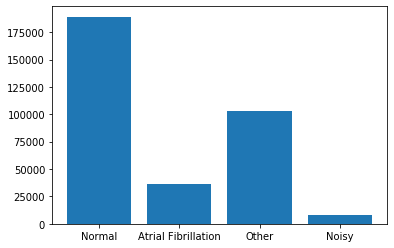

In [5]:
classes = ["Normal", "Atrial Fibrillation", "Other", "Noisy"]
dist = [0]*4

for ecg in np.load("trainingDataUNBALANCED.npy", allow_pickle=True):
  dist[np.argmax(ecg[1])] += 1

print(classes)
y_pos = np.arange(len(classes))

plt.bar(y_pos, dist, align='center')
plt.xticks(y_pos, classes)

500


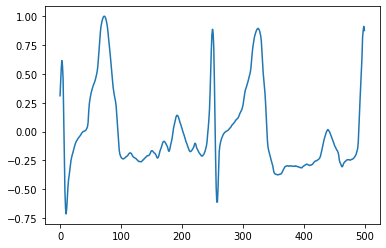

In [6]:
trainingData = np.load("trainingDataBALANCED.npy", allow_pickle=True)
ecg = trainingData[4][0]
print(len(ecg))
plt.plot(ecg)

In [0]:
try:
  trainingData = np.load("trainingDataBALANCED.npy", allow_pickle=True)
  print("Data from github")
except:
  trainingData = np.load("drive/My Drive/trainingData.npy", allow_pickle=True)
  print("Data from google dive")
ecg = trainingData[0][0]
print(len(ecg))
plt.plot(ecg)

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 180, 5, padding=2) 
        self.conv2 = nn.Conv1d(180, 150, 5, padding=2) 
        self.conv3 = nn.Conv1d(150, 120, 5, padding=2)
        self.conv4 = nn.Conv1d(120, 90, 5, padding=2)
        self.conv5 = nn.Conv1d(90, 60, 5, padding=2)

        x = torch.randn(1,1,500).view(-1,1,500)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 500)
        self.fc2 = nn.Linear(500, 4)

    def convs(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), 3)
        x = F.max_pool1d(F.relu(self.conv2(x)), 3)
        x = F.max_pool1d(F.relu(self.conv3(x)), 2)
        x = F.max_pool1d(F.relu(self.conv4(x)), 3)
        x = F.max_pool1d(F.relu(self.conv5(x)), 3)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]
        return x


    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)


net = Net().to(device)
print(net)

X = torch.Tensor([i[0] for i in trainingData])
y = torch.Tensor([i[1] for i in trainingData])
 
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

train_data = trainingData[:-val_size]

test_data = trainingData[-val_size:]

print(len(train_X), len(test_X))

 # insample accuracy & insample loss
 # outsample accuracy & outsample loss
class training():
  optimizer = optim.Adam(net.parameters(), lr = 0.001)#, weight_decay=1e-5)
  loss_function = nn.CrossEntropyLoss()#weight=1/torch.Tensor(list(Data_PreProcessing.dataCount.values())))
  PATH = "/content/drive/My Drive/ECG_MODELS/"

  def train(self):
    net = Net().to(device).apply(self.weight_reset)
    layers, params = self.net_info(net)
    MODEL_NAME = f"layers-{layers}_parms-{str(params)[1:-1].replace(', ', '_')}_model-{int(time.time())}"
    BATCH_SIZE = 5000
    EPOCHS = 100

    with open(self.PATH+"data/"+f"{MODEL_NAME}.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
            for i in range(0, len(train_X), BATCH_SIZE):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,500)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = self.fwd_pass(batch_X, batch_y, train=True)
                
                if i % 50 == 0:
                    val_acc, val_loss = self.test(size=100)
                    f.write(f"{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)},{epoch}\n")

    torch.save(net, self.PATH+"model_params/"+f'{MODEL_NAME}.pt')

    model_data = open(self.PATH+"model_data/"+f"{MODEL_NAME}.txt", "w")
    model_data.write(str(net))
    model_data.write("/n")
    model_data.write(str(self.optimizer))
    model_data.write("/n")
    model_data.write(str(self.loss_function))
    model_data.close()

    return MODEL_NAME, EPOCHS

  def fwd_pass(self, X, y, train=False):
    if train:
      net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss_function = nn.CrossEntropyLoss().to(device)
    loss = loss_function(outputs, torch.argmax(y, 1))
    if train:
      loss.backward()
      self.optimizer.step()
    return acc, loss

  def test(self,size=100):
      X, y = test_X[:size], test_y[:size]
      val_acc, val_loss = self.fwd_pass(X.view(-1, 1, 500).to(device), y.to(device))
      return val_acc, val_loss

  def net_info(self, net):
    params = []
    for layers, m in enumerate(net.modules()):
      params.append(int(''.join(filter(lambda x: x.isdigit(),str((str(m).split(',')[1]))))))

    return layers, params

  def weight_reset(self, m):
      if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
          m.reset_parameters()
def graph_data(MODEL_NAME, EPOCHS):
  style.use("ggplot")
  PATH = "/content/drive/My Drive/ECG_MODELS/"

  contents = open(PATH+"data/"+f"{MODEL_NAME}.log", "r").read().split("\n")
  times = []
  accuracies = []
  losses = []
  mean_loss = []
  mean_acc = []
  val_accs = []
  val_losses = []
  
  contents = (c.split(",") for c in contents[:-1])
  for temp in list(contents):

    times.append(float(temp[0]))
    accuracies.append(float(temp[1]))
    losses.append(float(temp[2]))
    
    val_accs.append(float(temp[3]))
    val_losses.append(float(temp[4]))


  print("Best Valid Accuracy:", max(val_accs))
  times = (np.asarray(times) - min(times))
  times = times/np.amax(times)
  times = times * EPOCHS
  fig = plt.figure(figsize=(20, 10))
  ax1 = plt.subplot2grid((2,1), (0,0))
  ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

  ax1.set_ylim([0,1])
  ax1.set_ylabel('Accuracy (0.0-1.0)')
  ax1.plot(times, accuracies, label="Training Set Accuracy")
  ax1.plot(times, val_accs, label="Validation Set Accuracy")
  ax1.plot(times, abs(np.array(val_accs)-np.array(accuracies)), label="Δ Accuracy (between Training & Validation Set)")
  ax1.legend(loc=2)

  ax2.set_ylim([0,2])
  ax2.set_ylabel('Loss (0.0-2.0)')
  ax2.set_xlabel(f'Epochs (0-{EPOCHS})')
  ax2.plot(times, losses, label="Training Set Loss")
  ax2.plot(times, val_losses, label="Validation Set Loss")
  ax2.plot(times, abs(np.array(val_losses)-np.array(losses)), label="Δ Loss (between Training & Validation Set)")
  ax2.legend(loc=2)
  plt.savefig(PATH+"graphs/"+MODEL_NAME)
  plt.show()
train_model = training()
MODEL_NAME, EPOCHS = train_model.train()
graph_data(MODEL_NAME, EPOCHS)

Data from github
500
Net(
  (conv1): Conv1d(1, 180, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(180, 150, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(150, 120, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4): Conv1d(120, 90, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv5): Conv1d(90, 60, kernel_size=(5,), stride=(1,), padding=(2,))
  (fc1): Linear(in_features=180, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

5940
53465 5940


 12%|█▏        | 12/100 [58:44<7:17:36, 298.37s/it]

In [0]:
! mkdir data_2D

def _1D_to_2D(trainingData):
  ECG_PER_FILE = 375
  trainingData_2D = []

  file_count, ecg_count = 0, 0
  for ecg_data in tqdm(trainingData):
    img = np.array([[[0 for i in range(181)] for i in range(181)]][0])
    ecg_data[0] = (ecg_data[0] * 90) + 90

    col = 0
    for mV in ecg_data[0]:
      try:
        img[int(mV)][col] = 1
      except Exception as e:
        print(e)
      col += 1
    trainingData_2D.append([img, ecg_data[1]])
    ecg_count += 1
    

    if ecg_count % ECG_PER_FILE == 0:
      np.save(f"data_2D/imgData{file_count}.npy", trainingData_2D)
      file_count += 1
      del trainingData_2D
      trainingData_2D = []

  np.save(f"data_2D/imgData{file_count}.npy", trainingData_2D)

_1D_to_2D(trainingData)

In [0]:
test = np.load("data_2D/imgData0.npy", allow_pickle=True)[0][0]
plt.imshow(test)

In [0]:
import shutil
shutil.make_archive("data_2D_ZIP", 'zip', "data_2D")

In [0]:
from google.colab import files
import os
#files.download("/content/trainingDataBALANCED.npy") 

In [0]:
from google.colab import drive
drive.mount('/content/drive')